In [1]:
import tensorflow as tf

import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/anton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from keras.layers import Input, LSTM, RepeatVector, Dense, Embedding, Activation, Masking, SimpleRNN
from keras.layers.wrappers import TimeDistributed
from keras.models import Model, Sequential
from keras import backend as K

In [3]:
from functools import reduce
from tqdm import tqdm

### Synthetic dataset

- 4 - is a start symbol
- 3 - end symbol
- 0 - empty pos in the end of seq, used to equalize seqences lenghts

Data consists of two type of sequences seq_1 and seq_2

In [3]:
seq_1 = np.array([4, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0])
seq_2 = np.array([4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0])
X = np.vstack((np.tile(seq_1, (1000, 1)), np.tile(seq_2, (1000, 1))))

In [4]:
indexes = np.arange(X.shape[0])
np.random.shuffle(indexes)
X = X[indexes]

Y is one-hot encoded X

In [5]:
VOC_SIZE = 4
Y = np.zeros((X.shape[0], X.shape[1], VOC_SIZE+1))
mask = np.zeros_like(X)

In [6]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if X[i,j] != 0:
            Y[i,j,X[i,j]] = 1
            mask[i, j] = 1

### Spacers data

In [4]:
VOC_SIZE = 6
mask_val = 0

In [206]:
with open("./data/CRISPR_db_2109.txt") as f:
    lines = f.readlines()

In [207]:
lines = [x.split("\t")[1:] for x in lines]

lines = [[y for y in x if len(y) < 100 and len(y) > 5] for x in lines]

lines = reduce(lambda a,b: a+b, lines)

In [210]:
len(lines)

24809

In [213]:
lines = list(set(lines))

In [215]:
indexes = np.argsort([len(x) for x in lines])[:-1]

In [217]:
lines = np.array(lines)[indexes]

In [218]:
max_len = max([len(x) for x in lines])

In [5]:
max_len = 49

In [8]:
l_to_n = dict()
l_to_n["A"] = 1
l_to_n["C"] = 2
l_to_n["G"] = 3
l_to_n["T"] = 4

letters = set(["A", "C", "T", "G"])

In [9]:
total_missed = 0

def process_spacer(spacer):
    spacer_as_array = np.zeros(max_len + 2)
    spacer_as_array[0] = 5
    for i, el in enumerate(spacer):
        if el in letters:
            spacer_as_array[i + 1] = l_to_n[el]
        
    spacer_as_array[len(spacer) + 1] = 6
    return spacer_as_array

In [10]:
process_spacer("AGTGCTGGACCATTTCAAATTCACAATAGATT")

array([ 5.,  1.,  3.,  4.,  3.,  2.,  4.,  3.,  3.,  1.,  2.,  2.,  1.,
        4.,  4.,  4.,  2.,  1.,  1.,  1.,  4.,  4.,  2.,  1.,  2.,  1.,
        1.,  4.,  1.,  3.,  1.,  4.,  4.,  6.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [224]:
X = np.empty((len(lines), max_len + 2))

for i, l in enumerate(lines):
    try:
        X[i] = process_spacer(l)
    except:
        print(l)
        
X = X.astype(int)

In [225]:
Y = np.zeros((X.shape[0], X.shape[1], VOC_SIZE + 1))
mask_Y = np.zeros_like(X)

In [226]:
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Y[i,j,X[i,j]] = 1

100%|██████████| 1752/1752 [00:00<00:00, 34019.05it/s]


In [227]:
out_dim = 10

In [228]:
X.shape

(1752, 51)

In [229]:
Y.shape

(1752, 51, 7)

#### Small subset

In [16]:
X_ = np.tile(X[:100], (100, 1))
Y_ = np.tile(Y[:100], (100, 1, 1))

In [230]:
np.save("./spacers_as_array", X)
np.save("./spacers_as_OH_array", Y)

### Dataset remake

In [30]:
VOC_SIZE = 6
mask_val = 0
out_dim = 20
LSTM_INTERNAL_DIM = 200

In [21]:
X = np.load("./spacers_as_array.npy")
Y = np.load("./spacers_as_OH_array.npy")

## Net

In [34]:
encoder_input = Input(shape=(None,))

encoder_embedding_layer = Embedding(VOC_SIZE + 1, out_dim, mask_zero=True)
encoder_embedding = encoder_embedding_layer(encoder_input)

encoder_recurent_layer_1 = LSTM(LSTM_INTERNAL_DIM, return_state=True, return_sequences=True )
encoder_recurent_1, encoder_h, encoder_c = encoder_recurent_layer_1(encoder_embedding)

encoder_out_layer = TimeDistributed(Dense(VOC_SIZE, activation='softmax'))
encoder_out = encoder_out_layer(encoder_recurent_1)


#DECODER 
decoder_input = Input(shape=(None,))

decoder_embedding = encoder_embedding_layer(decoder_input)

decoder_recurent_layer_1 = LSTM(LSTM_INTERNAL_DIM, return_sequences=True, return_state=True)
decoder_recurent_1, _, _  = decoder_recurent_layer_1(decoder_embedding, initial_state = [encoder_h, encoder_c])

decoder_out_layer = TimeDistributed(Dense(VOC_SIZE, activation='softmax'))
decoder_out = decoder_out_layer(decoder_recurent_1)


In [35]:
encoder = Model(encoder_input, [encoder_h, encoder_c])

total_model = Model([encoder_input, decoder_input], decoder_out)

In [38]:
total_model.load_weights("./RAE/weights-improvement-200-intLSTM.hdf5", by_name=False)
total_model.compile(optimizer='adam', loss='categorical_crossentropy')


##### Decoder forward model

In [40]:
initial_decoder_h = Input(shape=(LSTM_INTERNAL_DIM,))
initial_decoder_c = Input(shape=(LSTM_INTERNAL_DIM,))

decoder_recurent_out, decoder_h, decoder_c = decoder_recurent_layer_1(decoder_embedding,
                                                                      initial_state=[initial_decoder_h, initial_decoder_c])
decoder_true_out  = decoder_out_layer(decoder_recurent_out)

In [41]:
total_decoder = Model([decoder_input, initial_decoder_h, initial_decoder_c], decoder_true_out)

## Give it a try

In [39]:
total_model.evaluate([X[2:3], X[2:3, :-11]], Y[2:3, 1:-10, 1:])

1/1 [==============================] - 1s 676ms/step


0.053607355803251266

In [40]:
X[2:3]

array([[5, 1, 1, 2, 1, 4, 2, 3, 3, 1, 1, 1, 2, 3, 3, 2, 4, 4, 2, 3, 2, 3,
        3, 2, 3, 3, 2, 3, 3, 2, 3, 4, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [411]:
pairs_inline = pairs.reshape(-1, 51).astype(int)
pairs_inline_Y = np.zeros((pairs_inline.shape[0], 51, VOC_SIZE + 1))

In [412]:
for i in range(pairs_inline.shape[0]):
    for j in range(pairs_inline.shape[1]):
        if pairs_inline[i,j] != 0:
            pairs_inline_Y[i,j,pairs_inline[i,j]] = 1

In [418]:
pairs_inline_Y.shape

(149254, 51, 7)

In [420]:
total_model.evaluate([pairs_inline[:1000, :-1], pairs_inline[:1000, :-1]], pairs_inline_Y[:1000, 1:, 1:])

1000/1000 [==============================] - 2s 2ms/step


0.093096302866935723

In [42]:
h_, c_ = encoder.predict(X[0:1])

In [72]:
total_decoder.predict([np.array([[5, 1, 1, 2, 1, 4, 2, 3, 3, 1, 1, 1, 2, 3, 3, 2, 4, 4, 2, 3, 2, 3,
        3, 2, 3, 3, 2, 3, 3]]), h_, c_])[0][-1]

array([  9.95627522e-01,   3.98824841e-06,   1.57810061e-03,
         2.79031903e-03,   5.11958358e-11,   8.30568609e-08], dtype=float32)

In [47]:
## GIAT 2

In [500]:
with open("./data/ES/ES1_R1_spacers.txt") as f:
    lines = f.readlines()
    
lines = [x[:-2][:47] for x in lines[1:]]

In [606]:
with open("./data/ES/ES1_R1_pairs.txt") as f:
    lines = f.readlines()

pairs = [p[:-2].split(" ") for p in lines]

pairs = np.array([[process_spacer(p[0][:49]),process_spacer(p[1][:49])] for p in pairs])

In [513]:
lines[0]

'GGGCGCACGGAATACAAAGCCGTGTATCTGCT TGGCTCTGCAACAGCAGCACCCATGACCACGT\n'

In [521]:
pairs[:2]

unique_pairs = np.unique(pairs, axis = 0)

In [522]:
unique_pairs.shape

(2464, 2, 51)

In [607]:
h_0, c_0 = encoder.predict(pairs[:,0,:], verbose=1)

79827/79827 [==============================] - 74s 928us/step


In [608]:
h_1, c_1 = encoder.predict(pairs[:,1,:], verbose=1)

79827/79827 [==============================] - 76s 947us/step


In [525]:
normalize = lambda x: x / ((x)**2).sum(1)[0]
h_0 = normalize(h_0)
h_1 = normalize(h_1)
c_0 = normalize(c_0)
c_1 = normalize(c_1)

In [609]:
h_c_0 = np.concatenate((h_0, c_0), axis = 1)
h_c_1 = np.concatenate((h_1, c_1), axis = 1)

In [610]:
h_c = np.concatenate((h_c_0, h_c_1))

In [611]:
h_c.shape

(159654, 400)

In [612]:
h_c_unique = np.unique(h_c, axis = 0)

In [613]:
h_c_unique.shape

(1885, 400)

### Clustering

In [614]:
from sklearn.cluster import KMeans

kmeans = KMeans(30, verbose=0)

In [615]:
kmeans.fit(h_c_unique)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [616]:
clusters_0 = kmeans.predict(h_c_0)
clusters_1 = kmeans.predict(h_c_1)

In [617]:
clusters_pairs = np.concatenate((clusters_0.reshape(-1, 1), clusters_1.reshape(-1, 1)), 1)

In [536]:
clusters.shape[0] / 2

2464.0

In [338]:
clusters_0[:10]

array([41, 41,  4, 85, 11,  2, 36, 69, 41,  4], dtype=int32)

In [339]:
clusters_1[:10]

array([21, 21, 21, 14, 13,  3, 21, 78, 21, 93], dtype=int32)

In [341]:
from tqdm import tqdm

In [653]:
np.linalg.norm(h_0[0])

6.409543

In [654]:
np.linalg.norm(c_0[0])

182.22643

Brief check

In [64]:
h1, c1 = encoder.predict(np.array([[5, 1, 1, 2, 1, 4, 2, 3, 3, 1, 1, 1, 2, 3, 3, 2, 4, 4, 2, 3, 2, 3, 
                                    3, 2, 3, 3, 2, 3, 3]]))

In [65]:
h2, c2 = encoder.predict(np.array([[5, 1, 1, 2, 2, 4, 2, 3, 3, 1, 1, 1, 2, 3, 3, 2, 4, 4, 2, 3, 2, 3, 
                                    3, 2, 3, 3, 2, 3, 3]]))

In [73]:
((c1[0] - c2[0])**2).mean()

0.17987101

In [78]:
np.sqrt(((c1)**2).sum())

155.11412

In [70]:
h2[0][:10]

array([  2.31739179e-07,  -0.00000000e+00,  -1.50188133e-01,
         0.00000000e+00,  -9.06994760e-01,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -7.02618420e-01,
        -0.00000000e+00], dtype=float32)

## TSNE

In [367]:
from sklearn.manifold import TSNE

In [368]:
tsne = TSNE(verbose=1)

In [604]:
tsne_res = tsne.fit_transform(np.concatenate((h_c_0, h_c_ans)))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 962 samples in 0.013s...
[t-SNE] Computed neighbors for 962 samples in 0.914s...
[t-SNE] Computed conditional probabilities for sample 962 / 962
[t-SNE] Mean sigma: 5.260690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.055813
[t-SNE] Error after 1000 iterations: 0.258932


In [422]:
tsne_res

array([[ 39.00012207, -31.8522644 ],
       [ 38.99681473, -31.85448647],
       [ 40.64165115, -32.52663422],
       ..., 
       [ 15.93553925, -27.40551949],
       [  2.97838283, -10.98081589],
       [ -5.57502747, -32.32271194]], dtype=float32)

In [444]:
from matplotlib import cm

In [460]:
cluster_colors.shape

(2232, 4)

In [461]:
tsne_res.shape

(2232, 2)

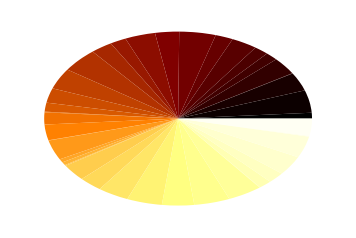

In [494]:
colors = cm.afmhot(np.arange(40) / 40.)

_ = plt.pie(np.random.random(40), colors=colors)

In [598]:
cluster_colors = np.zeros((clusters.shape[0], 4))

for i in range(clusters.shape[0]):
    cluster_colors[i] = colors[clusters[i]]

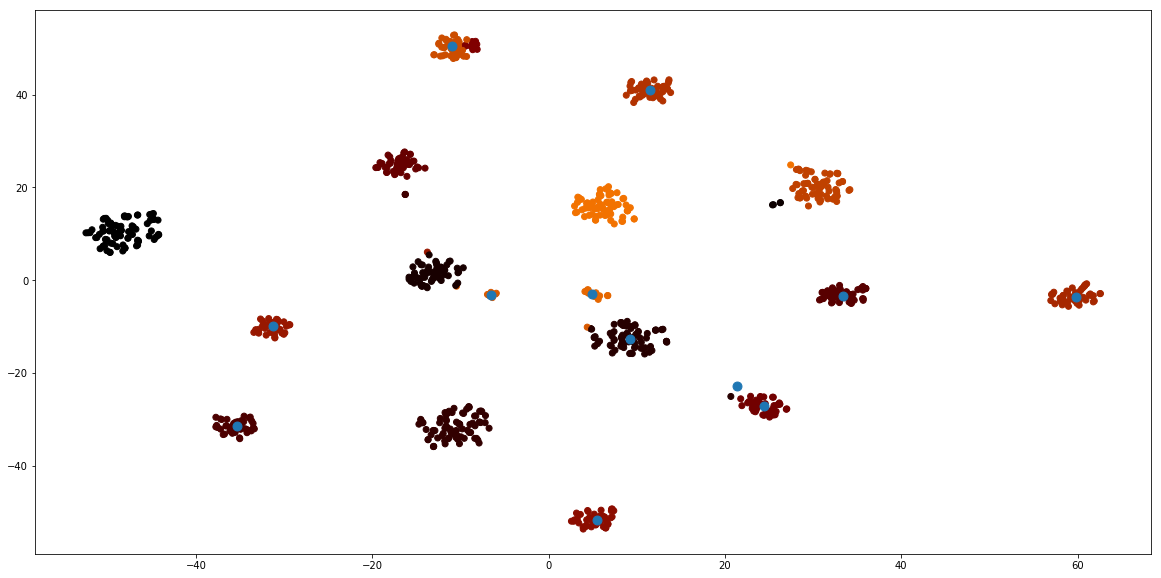

In [605]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(tsne_res[:-h_c_ans.shape[0],0], tsne_res[:-h_c_ans.shape[0], 1], c = cluster_colors[:])
ax.scatter(tsne_res[-h_c_ans.shape[0]:,0], tsne_res[-h_c_ans.shape[0]:, 1], s=80)

#for i in range(100):
#    ax.annotate(i, h_tsne[i])

In [498]:
clusters

array([29, 29, 29, 34, 13, 34, 34, 34, 29,  4,  4, 34, 13, 29, 19, 19, 34,
       13, 21, 34, 34, 21,  4, 21, 34, 21,  4, 21, 19, 19, 39, 21, 18, 21,
       19, 19, 21, 34, 21, 21,  4, 34, 21, 21, 34, 34, 34, 19, 34, 34, 35,
        7, 21, 34,  4, 34, 34,  7, 24, 19, 21, 12, 24, 12, 39,  3,  3, 35,
        8, 34, 34, 34, 26, 39, 24,  3, 39, 39,  7, 38, 39, 24, 24, 39, 24,
       24,  3,  3, 24,  3, 24,  3, 24,  2, 24,  3, 24,  3, 31, 39], dtype=int32)

In [499]:
h_c_unique

array([[ -1.05483478e-09,  -0.00000000e+00,  -2.82662036e-03, ...,
          6.96010131e-04,   6.98301941e-04,  -5.77143859e-04],
       [ -7.82061527e-10,  -0.00000000e+00,  -2.83102063e-03, ...,
          6.96542964e-04,   6.95357332e-04,  -5.77328959e-04],
       [ -5.24903454e-10,  -0.00000000e+00,  -3.19593237e-03, ...,
          7.02218735e-04,   6.92981877e-04,  -5.79275948e-04],
       ..., 
       [  6.48287005e-06,  -0.00000000e+00,  -2.01391173e-03, ...,
          7.29476218e-04,   7.34511937e-04,  -6.03482360e-04],
       [  1.41702640e-05,  -0.00000000e+00,  -2.44459044e-03, ...,
          7.03325146e-04,   7.08180421e-04,  -5.77856612e-04],
       [  1.60665186e-05,  -0.00000000e+00,  -3.00175929e-03, ...,
          7.30794913e-04,   7.33298541e-04,  -5.98588493e-04]], dtype=float32)

In [644]:
ans = "CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC	TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG	GTAGTCCATCATTCCACCTATGTCTGAACTCC	CCGGGGGATAATGTTTACGGTCATGCGCCCCC	TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG	AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC	TAGTTTCCGTATCTCCGGATTTATAAAGCTGA	GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG	GCGACCGCTCAGAAATTCCAGACCCGATCCAAA	TCAACATTATCAATTACAACCGACAGGGAGCC	AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG	TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG" + "	GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC	CTGTTTTCGCAAATCTATGGACTATTGCTATT	GGGCGCACGGAATACAAAGCCGTGTATCTGCT	TGGCTCTGCAACAGCAGCACCCATGACCACGT	GAAATGCTGGTGAGCGTTAATGCCGCAAACAC	ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC"

In [502]:
ans = "GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC	ACACGCCCTTATCAAATAGCTGTGATTTACCTA	ATAGACCCCGAACAACAATACGCGCAAACCGA	TACCGTACAGACTGCCGGATATTATTTTTTTG	CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG	AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC	TGCATGGCTTTGGCTTCCTCTTTGACGGACGC	ATATATCAGAGCAAAAAACAAAGCCACAGCCA	CATAAAGAAACTATTTTGCGTTTCGTTCAGGT	TTTTACAGTGTCAACAATCGTTCCCTGATTGT	CCGCCGTTGGCACCGTCAAACTCCGGTACTGT	TATAGAGATCGTTTTTGGAATTTACAGCGAGG	CCGTAAGTGGTTTGAGCGATGATATTTGTGCT"

In [645]:
ans_X = np.array([process_spacer(x) for x in ans.split("\t")])

In [646]:
h_ans, c_ans = encoder.predict(ans_X)

In [505]:
h_ans = normalize(h_ans)
c_ans = normalize(c_ans)

In [396]:
h_c_ans.shape

(12, 400)

In [647]:
h_c_ans = np.concatenate((h_ans, c_ans), 1)

In [394]:
np.sort((np.abs(h_c_unique - h_c_ans[6]) < 1e-16).sum(1))

array([43, 44, 44, ..., 61, 61, 65])

In [386]:
np.argsort((h_c_unique == h_c_ans[0]).sum(1))

array([ 290,  178,  437, ..., 1236, 1509,  301])

In [387]:
h_c_unique.shape

(2220, 400)

In [648]:
ans = kmeans.predict(h_c_ans)

In [649]:
ans

array([24,  3, 14,  6, 27,  7, 12, 18, 13, 15, 21, 28, 23, 22, 29, 19, 20,
       16], dtype=int32)

## GRAPH

In [666]:
graph = np.zeros((30,30))


for pair in tqdm(clusters_pairs):
    #graph[kmeans.predict(pair[0].reshape(1,-1)), kmeans.predict(pair[1].reshape(1,-1))] += 1
    graph[pair[0]][pair[1]] += 1

100%|██████████| 79827/79827 [00:00<00:00, 472308.05it/s]


In [667]:
graph = graph.astype(int)

In [668]:
heavy_edges_num = []
for i in range(3000): 
    heavy_edges_num.append((graph > i).sum())

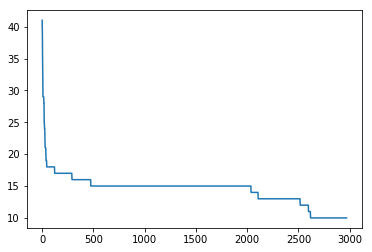

In [669]:
plt.plot(heavy_edges_num[30:])

In [672]:
graph[graph < 40] = 0

In [673]:
(graph !=0).sum()

29

In [365]:
def to_graph(gr):
    edges = []
    curr_weight = 1000
    while curr_weight > 100:
        lin_max = np.argmax(gr)
        curr_weight = np.max(gr)
        
        print(curr_weight)
        x, y = lin_max // gr.shape[0], lin_max % gr.shape[0]
        gr[x][y] = 0
        gr[y][x] = 0

        edges.append([x, y])
    
    return edges

In [366]:
to_graph(graph)

17220
8974
8489
4873
3782
2985
2982
2871
2211
1834
1808
1396
1147
1065
1011
611
289
267
232
187
185
184
179
177
161
151
144
135
133
131
130
130
128
122
119
116
111
109
107
101
101
99


[[41, 21],
 [4, 93],
 [2, 3],
 [32, 51],
 [20, 6],
 [85, 14],
 [69, 78],
 [7, 73],
 [77, 90],
 [11, 13],
 [28, 22],
 [59, 87],
 [9, 64],
 [36, 40],
 [96, 46],
 [70, 37],
 [39, 43],
 [2, 81],
 [2, 21],
 [41, 30],
 [2, 78],
 [41, 45],
 [2, 37],
 [2, 14],
 [41, 14],
 [2, 93],
 [41, 90],
 [2, 46],
 [41, 73],
 [41, 78],
 [2, 6],
 [41, 46],
 [41, 13],
 [41, 22],
 [41, 3],
 [2, 90],
 [2, 22],
 [2, 64],
 [41, 6],
 [31, 25],
 [41, 93],
 [41, 64]]

In [352]:
import networkx as nx

In [674]:
G=nx.Graph()

G.add_nodes_from(np.arange(30))

In [650]:
G_ans=nx.Graph()

G_ans.add_nodes_from(np.arange(30))

In [651]:
for i, j in zip(ans[:-1], ans[1:]):
    G_ans.add_edge(i, j)

In [675]:
for i, node in enumerate(graph):
    if node.sum() > 0:
        print([i, np.argmax(node)])
        G.add_edge(i, np.argmax(node))

[0, 4]
[3, 1]
[6, 8]
[7, 12]
[12, 18]
[13, 15]
[14, 6]
[15, 21]
[18, 2]
[19, 5]
[20, 16]
[21, 28]
[22, 17]
[23, 4]
[24, 3]
[25, 24]
[26, 5]
[27, 7]
[29, 26]


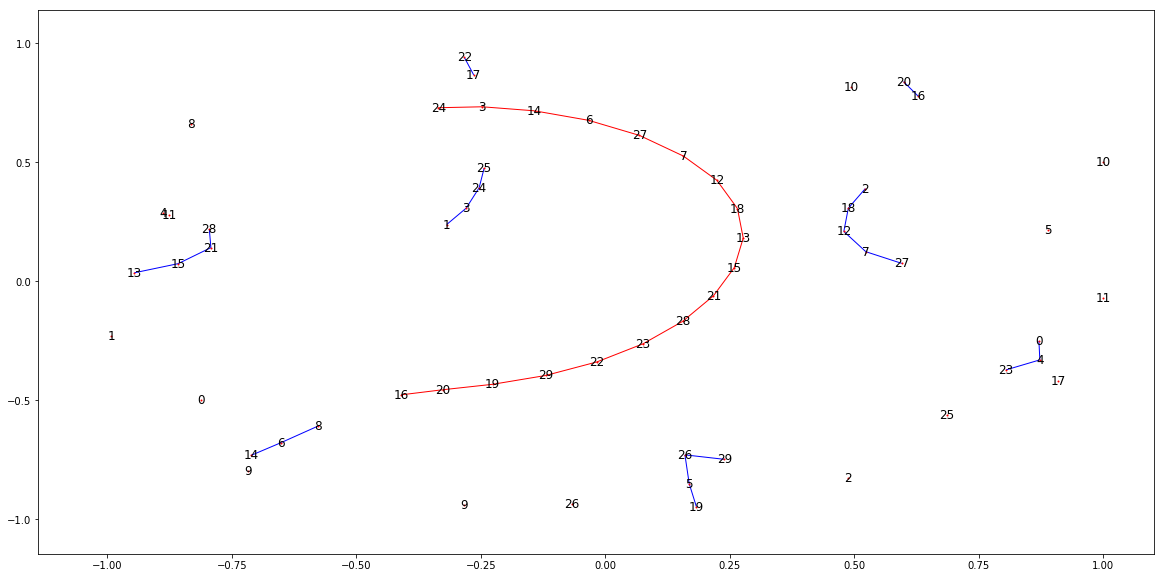

In [676]:
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw_networkx(G, edge_color='b', node_size=1)
nx.draw_networkx(G_ans, edge_color='r', node_size=1)
#nx.draw_networkx_edges(G, )
plt.show()

#### Coloring neurons

In [66]:
rnn_out_model = Model([decoder_input, initial_decoder_h, initial_decoder_c], decoder_recurent_out)

In [75]:
h_for_spacer = rnn_out_model.predict([X[0:1], h_, c_])[0]

In [104]:
(X[:100] > 0).sum(1)

array([32, 34, 34, 34, 34, 34, 34, 33, 34, 34, 34, 34, 34, 34, 34, 34, 32,
       35, 34, 34, 34, 34, 34, 34, 34, 33, 34, 34, 34, 33, 34, 34, 34, 34,
       34, 34, 33, 34, 34, 34, 33, 34, 34, 34, 33, 34, 34, 34, 34, 34, 34,
       34, 34, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 34,
       34, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 34, 34,
       34, 33, 34, 34, 34, 34, 34, 34, 33, 34, 34, 34, 33, 34, 34])

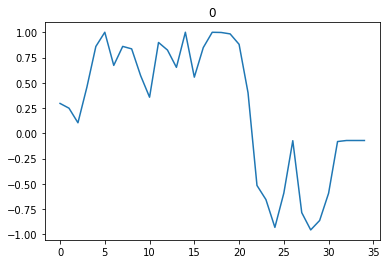

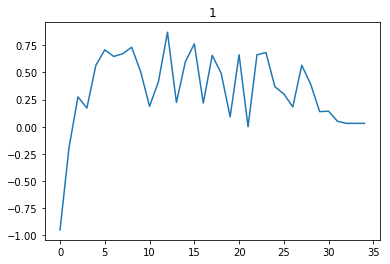

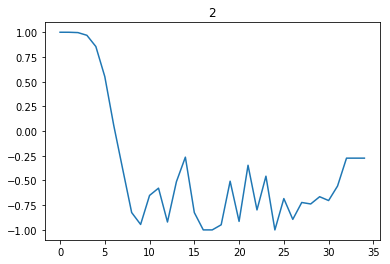

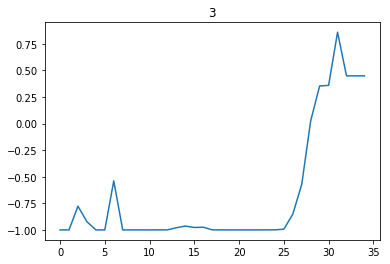

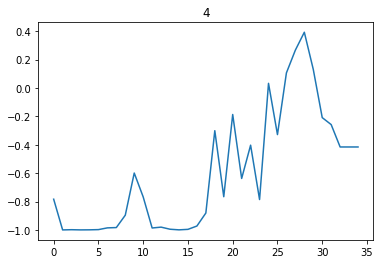

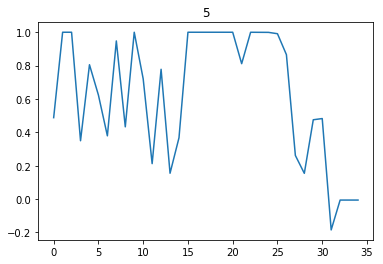

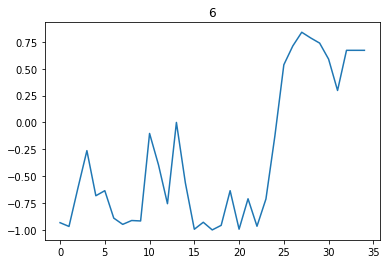

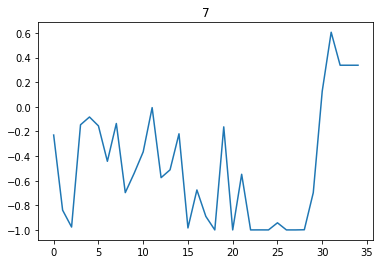

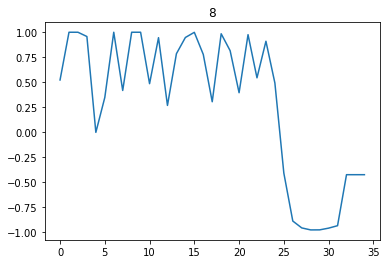

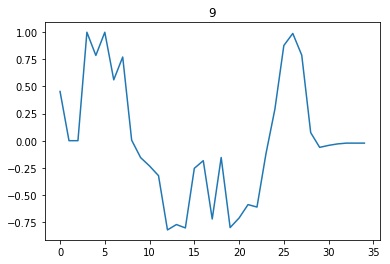

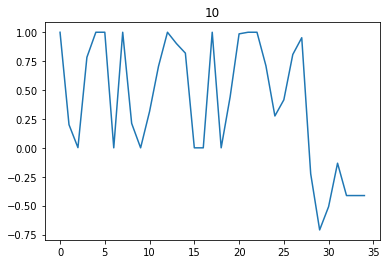

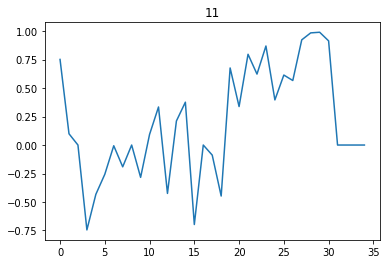

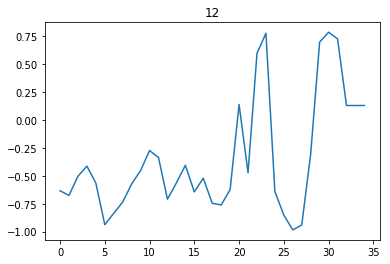

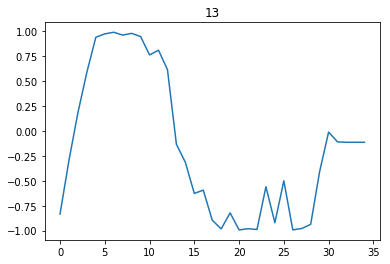

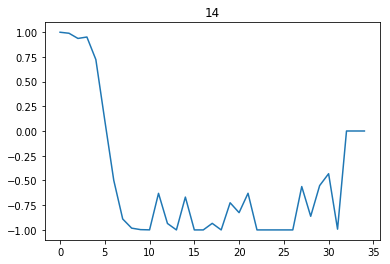

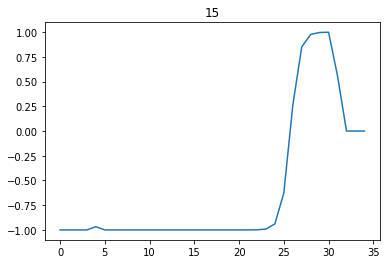

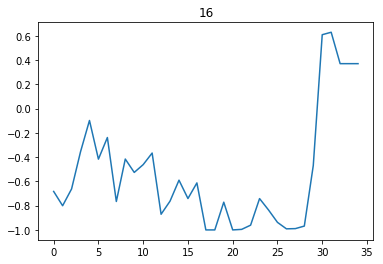

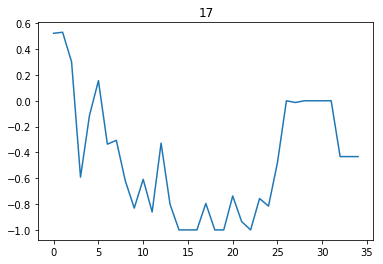

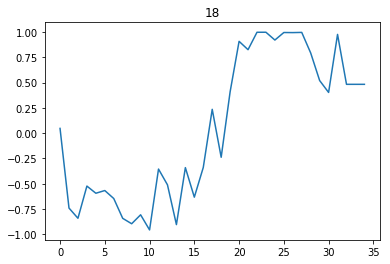

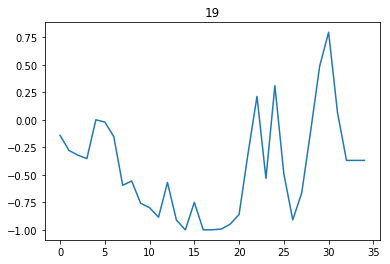

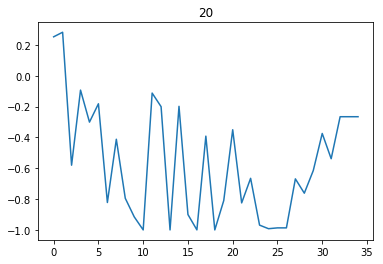

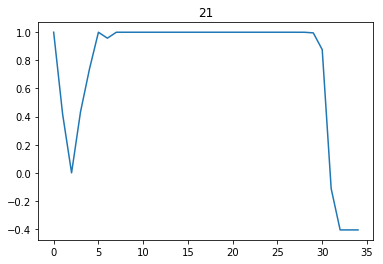

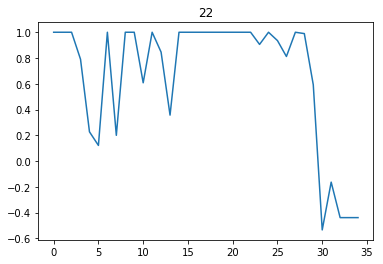

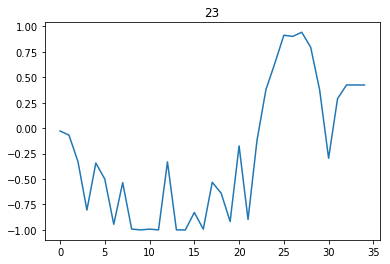

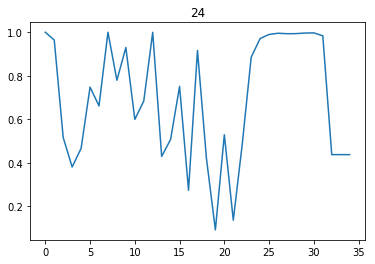

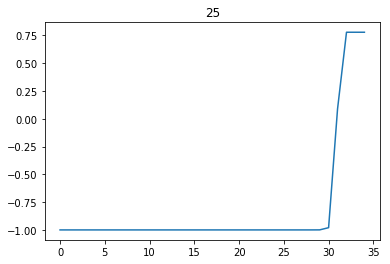

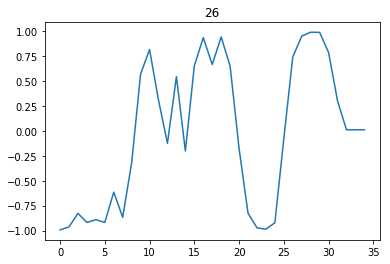

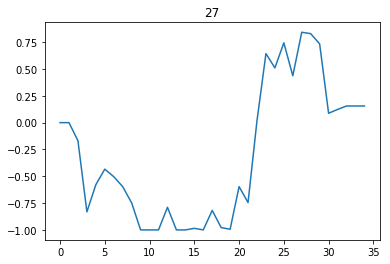

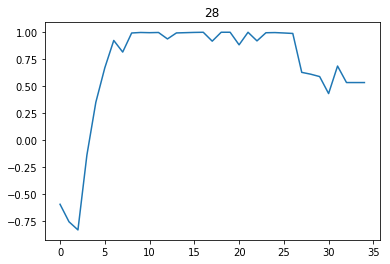

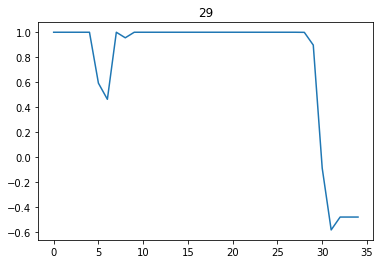

In [108]:
X_temp = X[7:8]
h_, c_ = encoder.predict(X_temp)
h_for_spacer = rnn_out_model.predict([X_temp, h_, c_])[0]
for i in range(30):
    plt.plot(h_for_spacer[:35, i])
    plt.title(i)
    plt.show()

In [109]:
np.array([x for x in zip(np.arange(X.shape[1]),X_temp[0])]).T

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68],
       [ 5,  3,  3,  1,  4,  4,  3,  4,  3,  3,  2,  1,  4,  2,  1,  3,  3,
         4,  3,  1,  4,  1,  4,  2,  3,  2,  2,  1,  1,  1,  1,  2,  6,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0]])